We install and load DuckLake, which gives us ACID storage on top of DuckDB.
Then we attach a local lakehouse database called mobility_lakehouse.
All Bronze, Silver, and Gold tables are created inside this lakehouse.

In [ ]:
import duckdb
import textwrap
#con = duckdb.connect(database=":memory:")  # in-memory for the session.
con = duckdb.connect()
print("DuckDB version:", duckdb.__version__)

In [ ]:
project_folder = 'C:/Users/ismae/OneDrive/Desktop/Master/BigData/project/'
#project_folder = 'C:/Users/sermi/OneDrive/Documentos/Big_Data/'
def SQL(q):
    """Run SQL (printed for clarity) and return a DataFrame."""
    #print("/nSQL>/n" + textwrap.dedent(q).strip())
    return con.execute(q).fetchdf()

print("DuckDB version:", con.sql("SELECT version();").fetchone()[0])

We start by importing DuckDB and creating a connection to the database.
We also define a helper function called SQL() which prints the SQL query and returns the result as a DataFrame. This allows us to work interactively using SQL inside a Python notebook.

In [ ]:
SQL("""INSTALL ducklake;""")

In [ ]:
SQL("""LOAD ducklake;""")


In [ ]:
SQL(f"""
ATTACH '{project_folder}local_data_store/lakehouse.db'
AS mobility_lakehouse
(READ_ONLY false);
""")


We set the active working schema to the lakehouse so all new tables are created there.


In [ ]:
SQL("""USE mobility_lakehouse;""")

We remove the Bronze table if it exists so we can rebuild it cleanly.


In [ ]:
SQL("""DROP TABLE IF EXISTS bronze_raw_mobility_trips
""")

## Bronze Layer

### 1. bronze_raw_mobility_trips
*Description:* Daily mobility flows from MITMA at district level (origin → destination)

| Column | Type | Description |
|--------|------|-------------|
| date | TEXT | YYYYMMDD string representing trip date |
| hour_period | TEXT | Hour of the day (HH) |
| origin_zone | TEXT | Origin district code (may contain 'externo') |
| destination_zone | TEXT | Destination district code |
| distance_category | TEXT | Distance category of trip |
| origin_activity | TEXT | Activity at origin |
| destination_activity | TEXT | Activity at destination |
| origin_study_possible | TEXT | 'sí'/'no' indicating if studying at origin is possible |
| destination_study_possible | TEXT | 'sí'/'no' indicating if studying at destination is possible |
| residence_province | TEXT | INE province code of residence |
| income_bracket | TEXT | Income bracket of traveler |
| age_bracket | TEXT | Age group of traveler |
| sex | TEXT | Sex of traveler |
| trips | TEXT | Number of trips (text, to be cast later) |
| trips_km | TEXT | Total distance in km (text) |

---

### 2. bronze_population_by_date_sex_age_nationality
*Description:* Population counts by sex, municipality, nationality, and age group

| Column | Type | Description |
|--------|------|-------------|
| sex | TEXT | Male/Female |
| nationality | TEXT | Spanish/Foreign |
| age_group | TEXT | Age category (large groups) |
| total | TEXT | Population count  |

---



### 2. silver_enriched_mobility_trips
*Description:* Enriched mobility table ready for analysis

| Column | Type | Description |
|--------|------|-------------|
| trip_timestamp | TIMESTAMP | Combined date + hour |
| hour_of_day | INTEGER | Hour of the day |
| origin_zone_id | TEXT | Cleaned origin zone (NULL if 'externo') |
| destination_zone_id | TEXT | Cleaned destination zone (NULL if 'externo') |
| origin_municipality_id | TEXT | First 5 digits of origin zone |
| destination_municipality_id | TEXT | First 5 digits of destination zone |
| residence_province_code | TEXT | INE province code |
| origin_activity | TEXT | Activity at origin |
| destination_activity | TEXT | Activity at destination |
| is_origin_study_possible | BOOLEAN | TRUE if studying at origin is possible |
| is_destination_study_possible | BOOLEAN | TRUE if studying at destination is possible |
| income_bracket | TEXT | Income bracket |
| age_bracket | TEXT | Age group |
| sex | TEXT | Sex |
| trip_count | DOUBLE | Number of trips |
| total_distance_reported_km | DOUBLE | Distance traveled in km |

---

### 3. silver_population_by_date_sex_age_nationality
*Description:* Cleaned and standardized population data

| Column | Type | Description |
|--------|------|-------------|
| municipality_code | TEXT | Extracted municipal code |
| municipality_name | TEXT | Extracted municipal name |
| year_of_data | INTEGER | Year of data |
| age_group | TEXT | Standardized age group |
| sex | TEXT | Standardized sex |
| nationality_status | TEXT | Spanish/Foreign |
| old_pop | TEXT | Original population value |
| population_count | BIGINT | Cleaned population value (0 if missing) |

Here we generate an ER diagram that summarizes the Bronze, Silver and Gold tables and their relationships.


In [ ]:
from IPython.display import SVG, display
import requests
import zlib
import base64

erd_diagram = """
erDiagram
    GOLD_CLUSTER_HOURLY_PATTERNS {
        TEXT origin_zone_id
        TEXT destination_zone_id
        INTEGER cluster
        INTEGER hour_of_day
        FLOAT avg_cluster_trips
        }

    GOLD_TOP_OD_FLOWS {
        TEXT origin_zone_id
        TEXT destination_zone_id
        FLOAT total_trips
        FLOAT total_distance_km
        FLOAT avg_distance_km
    }

    GOLD_MOBILITY_DAILY_PATTERN_BY_DISTRICT {
        TEXT origin_zone_id
        TEXT destination_zone_id
        INTEGER hour_of_day
        FLOAT avg_trips_per_hour
    }
    
    BRONZE_RAW_MOBILITY_TRIPS {
        TEXT date
        TEXT hour_period
        TEXT origin_zone
        TEXT destination_zone
        TEXT distance_category
        TEXT origin_activity
        TEXT destination_activity
        TEXT origin_study_possible
        TEXT destination_study_possible
        TEXT residence_province
        TEXT income_bracket
        TEXT age_bracket
        TEXT sex
        TEXT trips
        TEXT trips_km
    }
    
    BRONZE_POPULATION_BY_DATE_SEX_AGE_NATIONALITY {
        TEXT sex
        TEXT municipalities
        TEXT nationality
        TEXT age_groups
        TEXT period
        TEXT total
    }
    
    SILVER_ENRICHED_MOBILITY_TRIPS {
        TIMESTAMP trip_timestamp
        INTEGER hour_of_day
        TEXT origin_zone_id
        TEXT destination_zone_id
        TEXT origin_municipality_id
        TEXT destination_municipality_id
        TEXT residence_province_code
        TEXT origin_activity
        TEXT destination_activity
        BOOLEAN is_origin_study_possible
        BOOLEAN is_destination_study_possible
        TEXT income_bracket
        TEXT age_bracket
        TEXT sex
        DOUBLE trip_count
        DOUBLE total_distance_reported_km
    }
    
    SILVER_POPULATION_BY_DATE_SEX_AGE_NATIONALITY {
        TEXT municipality_code
        TEXT municipality_name
        INTEGER year_of_data
        TEXT age_group
        TEXT sex
        TEXT nationality_status
        TEXT old_pop
        BIGINT population_count
    }
    GOLD_CLUSTER_HOURLY_PATTERNS ||--|| SILVER_ENRICHED_MOBILITY_TRIPS : "aggregates_to"
    GOLD_TOP_OD_FLOWS ||--|| SILVER_ENRICHED_MOBILITY_TRIPS : "aggregates_to"
    GOLD_MOBILITY_DAILY_PATTERN_BY_DISTRICT ||--|| SILVER_ENRICHED_MOBILITY_TRIPS : "aggregates_to"
    BRONZE_RAW_MOBILITY_TRIPS ||--|| SILVER_ENRICHED_MOBILITY_TRIPS : "enriches_to"
    BRONZE_POPULATION_BY_DATE_SEX_AGE_NATIONALITY ||--|| SILVER_POPULATION_BY_DATE_SEX_AGE_NATIONALITY : "transforms_to"
    SILVER_POPULATION_BY_DATE_SEX_AGE_NATIONALITY ||--o{ SILVER_ENRICHED_MOBILITY_TRIPS : "origin_municipality_id"
    SILVER_POPULATION_BY_DATE_SEX_AGE_NATIONALITY ||--o{ SILVER_ENRICHED_MOBILITY_TRIPS : "destination_municipality_id"
"""

# Compress and encode
graphbytes = erd_diagram.encode("utf8")
compressed = zlib.compress(graphbytes, 9)
base64_bytes = base64.urlsafe_b64encode(compressed)
base64_string = base64_bytes.decode("ascii")

# Fetch SVG content
url = f"https://kroki.io/mermaid/svg/{base64_string}"
response = requests.get(url)

# Display as SVG (vector graphics - infinite quality)
display(SVG(response.content))

START WITH THE BRONZE TABLES 

## TABLE: bronze_raw_mobility_trips (MITMA)

We create the Bronze table matching the exact raw CSV structure, keeping all fields as text without any transformation.


In [ ]:
SQL("""CREATE TABLE bronze_raw_mobility_trips (
    date TEXT,
    hour_period TEXT,
    origin_zone TEXT,
    destination_zone TEXT,
    distance_category TEXT,
    origin_activity TEXT,
    destination_activity TEXT,
    origin_study_possible TEXT,
    destination_study_possible TEXT,
    residence_province TEXT,
    income_bracket TEXT,
    age_bracket TEXT,
    sex TEXT,
    trips TEXT,
    trips_km TEXT
);
""")

We load the raw CSV files directly into the Bronze table, storing the unmodified source data.


In [ ]:

trips_file=f'{project_folder}data/202201*_Viajes_distritos.csv.gz'
SQL(f"""
INSERT INTO bronze_raw_mobility_trips
SELECT *
FROM read_csv({trips_file}, UNION_BY_NAME=TRUE);

""")

We verify the Bronze table schema to ensure the structure is correct before transforming it.


In [18]:
SQL("""SELECT *
FROM information_schema.tables
WHERE table_name = 'bronze_raw_mobility_trips';
DESCRIBE bronze_raw_mobility_trips;

""")

,column_name,column_type,null,key,default,extra
0,date,VARCHAR,YES,None,None,None
1,hour_period,VARCHAR,YES,None,None,None
2,origin_zone,VARCHAR,YES,None,None,None
3,destination_zone,VARCHAR,YES,None,None,None
4,distance_category,VARCHAR,YES,None,None,None
5,origin_activity,VARCHAR,YES,None,None,None
6,destination_activity,VARCHAR,YES,None,None,None
7,origin_study_possible,VARCHAR,YES,None,None,None
8,destination_study_possible,VARCHAR,YES,None,None,None
9,residence_province,VARCHAR,YES,None,None,None


Quick preview of the Bronze data to confirm the raw CSVs were imported properly.


In [19]:
SQL("""SELECT *
FROM bronze_raw_mobility_trips

LIMIT 5;

""")

,date,hour_period,origin_zone,destination_zone,distance_category,origin_activity,destination_activity,origin_study_possible,destination_study_possible,residence_province,income_bracket,age_bracket,sex,trips,trips_km
0,20220101,00,01001,01009_AM,2-10,casa,frecuente,no,no,01,10-15,NA,NA,2.605,9.457
1,20220101,00,01001,01009_AM,2-10,no_frecuente,casa,no,no,01,>15,NA,NA,2.212,5.645
2,20220101,00,01001,01009_AM,2-10,frecuente,casa,no,no,01,>15,NA,NA,12.146,65.663
3,20220101,00,01001,01009_AM,2-10,frecuente,frecuente,no,no,01,>15,25-45,hombre,2.997,16.093
4,20220101,00,01001,01009_AM,2-10,frecuente,frecuente,no,no,01,>15,65-100,mujer,2.401,16.179


## TABLE: bronze_population_by_date_sex_age_nationality

We load the raw population CSV exactly as provided by the INE, keeping all fields in text format.


In [ ]:
popalation_file=f'{project_folder}data/33571.csv'
SQL(f"""
CREATE OR REPLACE TABLE bronze_population_by_date_sex_age_nationality AS
SELECT
    *
FROM
    read_csv({popalation_file})

""")

In [20]:
SQL("""SELECT * 
    FROM bronze_population_by_date_sex_age_nationality 
    LIMIT 3;

""")

,Sexo,Municipios,Nacionalidad,Edad (grandes grupos),Periodo,Total
0,Total,Total Nacional,Total,Todas las edades,1 de enero de 2022,47.475.420
1,Total,Total Nacional,Total,Todas las edades,1 de enero de 2021,47.385.107
2,Total,Total Nacional,Total,Todas las edades,1 de enero de 2020,47.450.795


## SILVER TABLE FOR bronze_population_by_date_sex_age_nationality

Here we transform the population data: splitting municipality text into code/name, converting year to integer, standardizing age groups, and casting population from text to numeric.


In [ ]:
SQL("""CREATE OR REPLACE TABLE silver_population_by_date_sex_age_nationality AS
SELECT
    -- 1. Municipios Splitting (Example: '37219 Navarredonda de la Rinconada')
    -- Extracts the first part (the municipal code)
    TRIM(SPLIT_PART(t1.Municipios, ' ', 1)) AS municipality_code,
    
    -- Extracts the rest of the string (the municipal name)
    TRIM(SUBSTRING(t1.Municipios, LENGTH(SPLIT_PART(t1.Municipios, ' ', 1)) + 2)) AS municipality_name,

    -- 2. Period/Date Standardization: Extract the year
    -- Example: '1 de enero de 2022' -> 2022
    CAST(SPLIT_PART(t1.Periodo, 'de ', -1) AS INTEGER) AS year_of_data,
    
    -- 3. Age Group Standardization
    CASE
        WHEN t1."Edad (grandes grupos)" = 'Menos de 16 años' THEN '0-15'
        WHEN t1."Edad (grandes grupos)" = 'Todas las edades' THEN 'Total'
        WHEN t1."Edad (grandes grupos)" LIKE '> 16%' THEN '16+' -- Handles >16 or similar summaries
        ELSE TRIM(t1."Edad (grandes grupos)") -- Keeps other granular groups as-is
    END AS age_group,
    
    -- 4. Categorical Standardization
    TRIM(t1.Sexo) AS sex,
    TRIM(t1.Nacionalidad) AS nationality_status,

    t1.Total as old_pop,
    
    -- 5. Total Population Cleaning
    CAST(
        -- If the result of the REPLACE operation is NULL (meaning it was blank), use '0'
        COALESCE(
            REPLACE(
                NULLIF(
                    NULLIF(TRIM(t1.Total), '""'), -- Converts " to NULL
                    ''                            -- Converts '' to NULL
                ), 
                '.', 
                ''
            ), 
            '0' -- Replaces the resulting NULL with '0'
        ) 
    AS BIGINT) AS population_count -- Cast to BIGINT
    

FROM
    bronze_population_by_date_sex_age_nationality AS t1 

-- 6. Filtering out Summary Rows (Keep only granular data for core analysis)
WHERE
    -- Filter out rows that are 'Total' Sex (keep Male/Female, if available)
    TRIM(t1.Sexo) != 'Total'
    
    -- Filter out rows that summarize everything (keep only specific groups like '0-15')
    AND TRIM(t1."Edad (grandes grupos)") != 'Todas las edades'
    
    -- Filter out national sums if focusing on mobility/municipal level
    AND TRIM(t1.Municipios) != 'Total Nacional'
    
    -- Filter out rows that summarize all nationalities
    AND TRIM(t1.Nacionalidad) != 'Total';
""")

In [21]:
SQL("""

SELECT*
FROM
    silver_population_by_date_sex_age_nationality AS t1
LIMIT 3;
""")

,municipality_code,municipality_name,year_of_data,age_group,sex,nationality_status,old_pop,population_count
0,44001,Ababuj,2022,0-15,Hombres,Española,4,4
1,44001,Ababuj,2021,0-15,Hombres,Española,3,3
2,44001,Ababuj,2020,0-15,Hombres,Española,3,3


We test the Silver population table by aggregating a specific age group to validate the cleaning process.


In [22]:
SQL("""--  JUST A TEST: SQL for Gold Layer Aggregation: 0-15 Age Group Sum by Municipality in this case only the year and municipality_code specified

SELECT
    t1.municipality_code,
    t1.municipality_name,
    -- Sum the population count
    SUM(t1.population_count) AS total_population_0_15_years
FROM
    silver_population_by_date_sex_age_nationality AS t1
WHERE
    -- Filter specifically for the standardized age group
    t1.age_group = '0-15' AND t1.year_of_data = 2022 AND t1.municipality_code == 44001
GROUP BY
    t1.municipality_code,
    t1.municipality_name
ORDER BY
    total_population_0_15_years DESC;
""")

,municipality_code,municipality_name,total_population_0_15_years
0,44001,Ababuj,6.0


## SILVER silver_enriched_mobility_trips

Here we convert text fields into analytical formats: combining date+hour into a timestamp, cleaning zone IDs, removing 'externo', deriving municipality codes, and converting trips and distance from text to numeric.


In [ ]:
SQL("""CREATE OR REPLACE TABLE silver_enriched_mobility_trips AS
SELECT
    -- 1. TIME STANDARDIZATION & FEATURE CREATION
    -- Combine date and hour_period (assuming 'date' is YYYYMMDD and 'hour_period' is HH)
    strptime(t1.date || t1.hour_period, '%Y%m%d%H') AS trip_timestamp,
    
    -- Extract the hour of the day
    CAST(t1.hour_period AS INTEGER) AS hour_of_day,
    
    -- 2. GEOGRAPHIC KEYS (Standardize zone IDs, converting 'externo' to NULL)
    NULLIF(TRIM(t1.origin_zone), 'externo') AS origin_zone_id,
    NULLIF(TRIM(t1.destination_zone), 'externo') AS destination_zone_id,
    
    LEFT(origin_zone_id, 5) AS origin_municipality_id,
    LEFT(destination_zone_id, 5) AS destination_municipality_id,

    -- Residence province code (INE code)
    TRIM(t1.residence_province) AS residence_province_code,

    -- 4. CATEGORICAL CLEANING & STANDARDIZATION
    TRIM(t1.origin_activity) AS origin_activity,
    TRIM(t1.destination_activity) AS destination_activity,
    
    -- Convert Spanish 'sí'/'no' flags to BOOLEAN
    (TRIM(t1.origin_study_possible) = 'sí') AS is_origin_study_possible,
    (TRIM(t1.destination_study_possible) = 'sí') AS is_destination_study_possible,
    
    -- Handle missing demographic values ('NA') by converting to NULL
    NULLIF(TRIM(t1.income_bracket), 'NA') AS income_bracket,
    NULLIF(TRIM(t1.age_bracket), 'NA') AS age_bracket,
    NULLIF(TRIM(t1.sex), 'NA') AS sex,

    -- 5. MEASURES (Ensure they are numeric and clean)
    CAST(NULLIF(TRIM(t1.trips), '') AS DOUBLE) AS trip_count,
    CAST(NULLIF(TRIM(t1.trips_km), '') AS DOUBLE) AS total_distance_reported_km
    
FROM
    bronze_raw_mobility_trips AS t1
-- Filter out records that are completely external if you're focusing only on internal mobility analysis
WHERE
    t1.origin_zone != 'externo' OR t1.destination_zone != 'externo';""")

We show a small sample to confirm timestamps, zone IDs, and numeric conversions are correct.


In [23]:
SQL("""SELECT *
    FROM silver_enriched_mobility_trips
    LIMIT 3""")

,trip_timestamp,hour_of_day,origin_zone_id,destination_zone_id,origin_municipality_id,destination_municipality_id,residence_province_code,origin_activity,destination_activity,is_origin_study_possible,is_destination_study_possible,income_bracket,age_bracket,sex,trip_count,total_distance_reported_km
0,2022-01-01,0,01001,01009_AM,01001,01009,01,casa,frecuente,False,False,10-15,None,None,2.605,9.457
1,2022-01-01,0,01001,01009_AM,01001,01009,01,no_frecuente,casa,False,False,>15,None,None,2.212,5.645
2,2022-01-01,0,01001,01009_AM,01001,01009,01,frecuente,casa,False,False,>15,None,None,12.146,65.663


## GOLD TABLES


## explain the table gold_top_od_flows

We aggregate Silver mobility data by origin–destination, computing total trips, total distance, and average distance per trip.


In [24]:
SQL("""
CREATE OR REPLACE TABLE gold_top_od_flows AS
SELECT
    -- 1. Origin and destination zones
    origin_zone_id,
    destination_zone_id,

    -- 2. Total number of trips for each OD pair
    SUM(trip_count) AS total_trips,

    -- 3. Total distance
    SUM(total_distance_reported_km) AS total_distance_km,

    -- 4. Average distance per trip 
    CASE 
        WHEN SUM(trip_count) > 0 
        THEN SUM(total_distance_reported_km) / SUM(trip_count)
        ELSE NULL
    END AS avg_distance_km

FROM silver_enriched_mobility_trips
WHERE origin_zone_id IS NOT NULL
  AND destination_zone_id IS NOT NULL
  AND trip_count IS NOT NULL

GROUP BY
    origin_zone_id,
    destination_zone_id

ORDER BY
    total_trips DESC;  -- Ranking by mobility intensity
""")


,Count
0,1463676


We check the aggregated OD flows to ensure the Gold metrics were calculated correctly.


In [25]:
SQL("SELECT * FROM gold_top_od_flows LIMIT 10")

,origin_zone_id,destination_zone_id,total_trips,total_distance_km,avg_distance_km
0,2807908,2807908,2.071850e+06,3.143077e+06,1.517038
1,0801910,0801910,1.819654e+06,2.107080e+06,1.157957
2,2807911,2807911,1.594942e+06,1.894194e+06,1.187626
3,2807916,2807916,1.512622e+06,2.214202e+06,1.463817
4,0801902,0801902,1.465181e+06,1.521886e+06,1.038702
5,04902,04902,1.340822e+06,5.277354e+06,3.935908
6,2807913,2807913,1.330019e+06,1.528351e+06,1.149120
7,0704004,0704004,1.223628e+06,2.745770e+06,2.243958
8,28106,28106,1.181452e+06,1.722090e+06,1.457605
9,38006,38006,1.152842e+06,4.587546e+06,3.979335


## Study of the avg_trips_per_hour separated by weekday and weekend with plot

We calculate average hourly trips for weekdays vs weekends by dividing total trips by the number of distinct days.


In [26]:
SQL("""CREATE OR REPLACE TABLE gold_mobility_daily_pattern_by_daytype AS
SELECT
  hour_of_day,
  'weekday' AS day_type,
  SUM(trip_count) / COUNT(DISTINCT day(trip_timestamp)) AS avg_trips_per_hour
FROM silver_enriched_mobility_trips
WHERE EXTRACT(DOW FROM trip_timestamp) BETWEEN 1 AND 5
GROUP BY hour_of_day

UNION ALL

SELECT
  hour_of_day,
  'weekend' AS day_type,
  SUM(trip_count) / COUNT(DISTINCT day(trip_timestamp)) AS avg_trips_per_hour
FROM silver_enriched_mobility_trips
WHERE EXTRACT(DOW FROM trip_timestamp) IN (0, 6) 
GROUP BY hour_of_day

ORDER BY 
  hour_of_day;
""")
df = SQL("SELECT * FROM gold_mobility_daily_pattern_by_daytype")

df.head()

,hour_of_day,day_type,avg_trips_per_hour
0,0,weekday,2.600691e+06
1,0,weekend,3.569895e+06
2,1,weekday,1.528784e+06
3,1,weekend,2.820410e+06
4,2,weekday,9.843217e+05


We visualize how mobility changes by hour comparing weekdays and weekends.


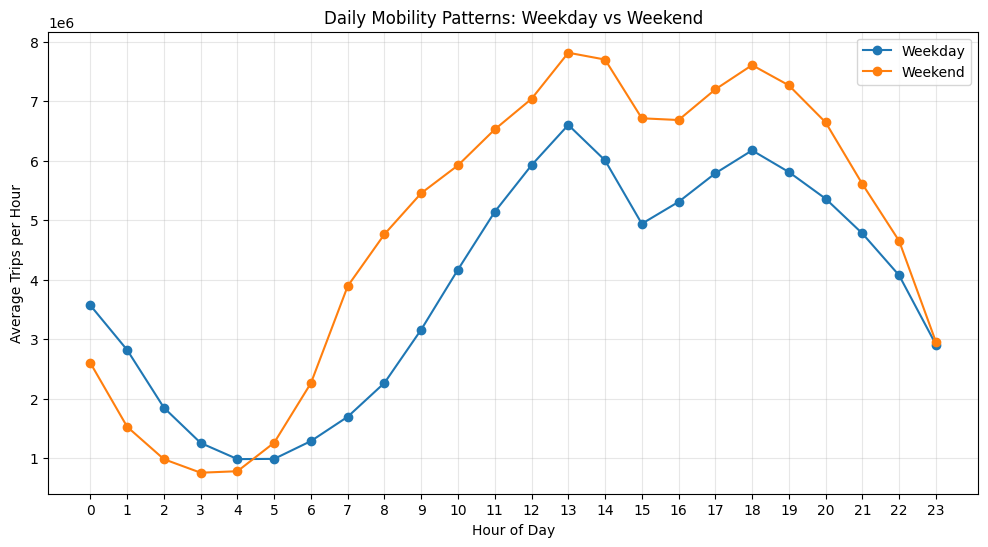

In [27]:
import matplotlib.pyplot as plt

pivot_df = df.pivot(index='hour_of_day', columns='day_type', values='avg_trips_per_hour')
pivot_df.columns = ['Weekend', 'Weekday'] 


plt.figure(figsize=(12, 6))
plt.plot(pivot_df.index, pivot_df['Weekday'], label='Weekday', marker='o')
plt.plot(pivot_df.index, pivot_df['Weekend'], label='Weekend', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trips per Hour')
plt.title('Daily Mobility Patterns: Weekday vs Weekend')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0,24))
plt.show()

We extend the hourly pattern calculation to each OD pair, separating weekday and weekend behaviors.


In [ ]:
#Same table as above but by origin-destination pairs instead of the whole country data
SQL("""CREATE OR REPLACE TABLE gold_mobility_daily_pattern_by_daytype_district AS
SELECT
    origin_zone_id,
    destination_zone_id,
  hour_of_day,
  'weekday' AS day_type,
  SUM(trip_count) / COUNT(DISTINCT day(trip_timestamp)) AS avg_trips_per_hour
FROM silver_enriched_mobility_trips
WHERE EXTRACT(DOW FROM trip_timestamp) BETWEEN 1 AND 5
GROUP BY origin_zone_id,destination_zone_id, hour_of_day

UNION ALL

SELECT
    origin_zone_id,
    destination_zone_id,
  hour_of_day,
  'weekend' AS day_type,
  SUM(trip_count) / COUNT(DISTINCT day(trip_timestamp)) AS avg_trips_per_hour
FROM silver_enriched_mobility_trips
WHERE EXTRACT(DOW FROM trip_timestamp) IN (0, 6) 
GROUP BY origin_zone_id, destination_zone_id,hour_of_day

ORDER BY 
  hour_of_day;
""")
df = SQL("SELECT * FROM gold_mobility_daily_pattern_by_daytype_district ")

df.head()

# First bussines Question: Typical Day in Mobility for a Reference Year:
## Clustering the average hourly origin-destination flows.

We compute hourly average trips for each origin–destination pair without separating weekday/weekend.


In [28]:
SQL("""CREATE OR REPLACE TABLE gold_mobility_daily_pattern_by_district AS
SELECT
    origin_zone_id,
    destination_zone_id,
  hour_of_day,
  SUM(trip_count) / COUNT(DISTINCT day(trip_timestamp)) AS avg_trips_per_hour
FROM silver_enriched_mobility_trips
GROUP BY origin_zone_id,destination_zone_id, hour_of_day
ORDER BY 
  hour_of_day;
""")
df = SQL("SELECT * FROM gold_mobility_daily_pattern_by_district ")

df.head()

,origin_zone_id,destination_zone_id,hour_of_day,avg_trips_per_hour
0,01009_AM,31138_AM,0,9.220000
1,01010,01054_AM,0,9.427286
2,0800902,0800902,0,9.642143
3,08011_AM,08191,0,5.123833
4,0801502,08291,0,1.510000


We pivot the table so each OD pair becomes one row with 24 hourly columns, preparing the dataset for clustering.


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Fetch the hourly averages grouped by zone
df = SQL("""
SELECT
    origin_zone_id,
    destination_zone_id,
    hour_of_day,
    avg_trips_per_hour
FROM gold_mobility_daily_pattern_by_district
""")

# Pivot: one row per zone x day_type, 24 columns
df_pivot = df.pivot_table(
    index=['origin_zone_id', 'destination_zone_id'],
    columns='hour_of_day',
    values='avg_trips_per_hour',
    fill_value=0
).reset_index()

df_pivot.head()


hour_of_day,origin_zone_id,destination_zone_id,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,01001,01001,0.000000,0.000000,0.0000,0.0000,0.000000,7.2190,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,01001,01002,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,01001,01009_AM,14.300173,6.708429,8.5884,3.3006,7.004167,9.3928,11.293833,15.219571,...,33.365714,26.037286,19.147000,18.807857,25.532286,24.691286,21.448286,24.487857,24.365571,18.404143
3,01001,01017_AM,4.625000,0.000000,0.0000,2.7880,2.377000,0.0000,2.732000,5.475000,...,9.026600,6.365500,5.538333,6.353750,7.361250,5.803500,6.737000,5.226000,2.310000,2.831000
4,01001,01028_AM,0.000000,0.000000,0.0000,0.0000,0.000000,5.5490,0.000000,9.133000,...,2.545000,0.000000,0.000000,2.315500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


We normalize the hourly values and apply KMeans to group OD pairs with similar daily mobility patterns.


In [30]:
# Extract only the hour columns
hour_cols = list(range(24))
X = df_pivot[hour_cols].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_pivot["cluster"] = clusters
df_pivot.head()


hour_of_day,origin_zone_id,destination_zone_id,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,cluster
0,01001,01001,0.000000,0.000000,0.0000,0.0000,0.000000,7.2190,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
1,01001,01002,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
2,01001,01009_AM,14.300173,6.708429,8.5884,3.3006,7.004167,9.3928,11.293833,15.219571,...,26.037286,19.147000,18.807857,25.532286,24.691286,21.448286,24.487857,24.365571,18.404143,3
3,01001,01017_AM,4.625000,0.000000,0.0000,2.7880,2.377000,0.0000,2.732000,5.475000,...,6.365500,5.538333,6.353750,7.361250,5.803500,6.737000,5.226000,2.310000,2.831000,3
4,01001,01028_AM,0.000000,0.000000,0.0000,0.0000,0.000000,5.5490,0.000000,9.133000,...,0.000000,0.000000,2.315500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3


We store the cluster results as a Gold table for easier analysis and reuse.


In [ ]:

con.register("clustered", df_pivot)


We inspect which OD pairs were assigned to each mobility pattern cluster.


In [33]:
SQL("""
SELECT * FROM clustered LIMIT 5;
""")

,origin_zone_id,destination_zone_id,0,1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,cluster
0,01001,01001,0.000000,0.000000,0.0000,0.0000,0.000000,7.2190,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
1,01001,01002,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
2,01001,01009_AM,14.300173,6.708429,8.5884,3.3006,7.004167,9.3928,11.293833,15.219571,...,26.037286,19.147000,18.807857,25.532286,24.691286,21.448286,24.487857,24.365571,18.404143,3
3,01001,01017_AM,4.625000,0.000000,0.0000,2.7880,2.377000,0.0000,2.732000,5.475000,...,6.365500,5.538333,6.353750,7.361250,5.803500,6.737000,5.226000,2.310000,2.831000,3
4,01001,01028_AM,0.000000,0.000000,0.0000,0.0000,0.000000,5.5490,0.000000,9.133000,...,0.000000,0.000000,2.315500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3


### The output might be an average hourly OD matrices grouped by origin-destination zones and clusters

We combine cluster labels with hourly patterns to compute the average hourly behavior of each cluster.


In [34]:
SQL("""CREATE OR REPLACE TABLE gold_cluster_hourly_patterns AS
    SELECT
    g.origin_zone_id,
    g.destination_zone_id,
    cluster,
    hour_of_day,
    AVG(avg_trips_per_hour) AS avg_cluster_trips
FROM gold_mobility_daily_pattern_by_district g
JOIN clustered c
    ON g.origin_zone_id = c.origin_zone_id
GROUP BY g.origin_zone_id,
    g.destination_zone_id, cluster, hour_of_day
ORDER BY cluster, hour_of_day;
""")


,Count
0,12444134


We preview the final cluster-based hourly patterns to validate the results.


In [ ]:
SQL("""
    SELECT *
    FROM gold_cluster_hourly_patterns g
    WHERE g.origin_zone_id == '0800902' and g.destination_zone_id== '0800902'
    LIMIT 15;
""")

,origin_zone_id,destination_zone_id,cluster,hour_of_day,avg_cluster_trips
0,0800902,0800902,3,0,9.642143
1,0800902,0800902,3,1,5.689333
2,0800902,0800902,3,2,3.053667
3,0800902,0800902,3,3,3.831800
4,0800902,0800902,3,4,2.421000
5,0800902,0800902,3,5,4.644333
6,0800902,0800902,3,6,3.273800
7,0800902,0800902,3,7,4.539667
8,0800902,0800902,3,8,6.398571
9,0800902,0800902,3,9,3.388714
